# Backtesting Framework. 

In [1]:
# Python module. 
import re, os 
import numpy as np 
import pandas as pd 
import pandas_datareader.data as web 
import matplotlib.pyplot as plt 
import pyfolio as pf 
import backtrader as bt 
from time import time 

# Change the current directory from (./notebook) to root directory. 
while not re.match(r".+MADS-CAP$", os.getcwd()): 
	os.chdir("..") 
	
print(f"Current directory: ({os.getcwd()})") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules.manage_files import ManageFiles 
from source.modules.backtesting import (
	format_time, FixedCommisionScheme, SignalData, 
	MLStrategy, RuleBasedStrategy, 
) 

# Custom configs. 
from source.config_py.config import (
	DIR_DATASET, DIR_DATASET_CONSOLIDATED, DIR_DATASET_UTIL, 
	TICKER_TO_COLLECT, TICKER_TO_EXCLUDE, TICKER_DATE_COLLECT, 
	PARAM_SEED, 
)

Current directory: (/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_697_/submission/MADS-CAP)


## Configurations (general). 

In [2]:
# Matplotlib setting. 
%matplotlib inline 

# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 50)

# File management setup. 
manage_files = ManageFiles() 

# Ensure reproducibility. 
np.random.seed(PARAM_SEED) 

# List of ticker to collect data. 
ticker_to_collect = TICKER_TO_COLLECT.difference(TICKER_TO_EXCLUDE) 

# # Uncomment this part to use Jeremy's stock pick. 
ticker_to_collect = set(manage_files.load_cache_pk(DIR_DATASET_UTIL, "jeremy_tickers_v1.pickle")) 
ticker_to_collect = ticker_to_collect.difference(TICKER_TO_EXCLUDE) 

# # Uncomment this to specify specific tickers here. 
ticker_to_collect = set(["AAPL", "AMZN", "TSLA", "JNJ", "BA", "LMT", "JPM", "GS"])

# Date range. 
date_beg, date_end = TICKER_DATE_COLLECT 

# For clearing the output. Not important. 
clear_output()

## Load consolidated ticker data. 

### Load dataset. 

In [3]:
filepath = os.path.join(DIR_DATASET_CONSOLIDATED, "consolidated_feature.parquet")
df_feature = pd.read_parquet(filepath) 

# Preview. 
df_feature 

,date,open,high,low,close,volume,dividends,stock_splits,ticker,return_c2c_lag1,tscore_c2c_lag1,return_c2c_lag1_autolag1,tscore_c2c_lag1_autolag1,return_c2c_lag1_autolag2,tscore_c2c_lag1_autolag2,return_c2c_lag1_autolag3,tscore_c2c_lag1_autolag3,vix_date,vix_open,vix_close,date_quarter,vl_ticker,vl_fiscalDateEnding,vl_eps,vl_eps_continuing,...,techind_macd_MACD,techind_macd_MACD_Hist,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI,candle_cdl3blackcrows,candle_cdldarkcloudcover,candle_cdldoji,candle_cdldojistar,candle_cdldragonflydoji,candle_cdlengulfing,candle_cdleveningdojistar,candle_cdleveningstar,candle_cdlhammer,candle_cdlhangingman,candle_cdlharami,candle_cdlinvertedhammer,candle_cdlmorningdojistar,candle_cdlmorningstar,candle_cdlrickshawman,candle_cdlshootingstar,candle_cdltristar
0,1999-11-23,8.44,8.44,8.44,8.44,60000.0,0.0,0.0,TDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-11-23,21.07,21.00,1999-12-31,None,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1999-11-24,8.44,10.69,8.44,10.50,917700.0,0.0,0.0,TDY,0.244076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-11-24,20.70,20.26,1999-12-31,None,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1999-11-26,10.50,10.50,10.50,10.50,32700.0,0.0,0.0,TDY,0.000000,NaN,0.244076,NaN,NaN,NaN,NaN,NaN,1999-11-26,20.35,22.33,1999-12-31,None,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1999-11-29,10.62,10.62,9.25,9.25,511000.0,0.0,0.0,TDY,-0.119048,NaN,0.000000,NaN,0.244076,NaN,NaN,NaN,1999-11-29,24.27,23.57,1999-12-31,None,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0
4,1999-11-30,9.38,9.38,8.50,8.81,2424000.0,0.0,0.0,TDY,-0.047568,NaN,-0.119048,NaN,0.000000,NaN,0.244076,NaN,1999-11-30,23.81,24.18,1999-12-31,None,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150137,2022-02-18,45.49,45.79,44.42,44.79,4823100.0,0.0,0.0,MOS,-0.022266,-1.762156,-0.005859,-0.513109,0.015649,1.114151,0.021387,1.542408,2022-02-18,26.66,27.75,2022-03-31,MOS,2021-12-31,4.300888,4.291648,...,1.5046,0.0498,1.4548,43.7342,41.4175,36.1478,58.2486,57.2518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1150138,2022-02-22,45.50,45.63,43.38,43.99,7738900.0,0.0,0.0,MOS,-0.017861,-1.424631,-0.022266,-1.762156,-0.005859,-0.513109,0.015649,1.114151,2022-02-22,31.80,28.81,2022-03-31,MOS,2021-12-31,4.300888,4.291648,...,1.3406,-0.0913,1.4319,43.7581,41.5182,36.2258,55.5044,56.0585,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1150139,2022-02-23,42.59,45.59,42.16,44.99,9786700.0,0.0,0.0,MOS,0.022732,1.672452,-0.017861,-1.424631,-0.022266,-1.762156,-0.005859,-0.513109,2022-02-23,28.04,31.02,2022-03-31,MOS,2021-12-31,4.300888,4.291648,...,1.2770,-0.1239,1.4009,43.8755,41.6544,36.3130,58.0956,57.1937,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1150140,2022-02-24,43.93,47.89,43.87,45.14,10706300.0,0.0,0.0,MOS,0.003334,0.185045,0.022732,1.672452,-0.017861,-1.424631,-0.022266,-1.762156,2022-02-24,37.50,30.32,2022-03-31,MOS,2021-12-31,4.300888,4.291648,...,1.2246,-0.1411,1.3657,43.9959,41.7911,36.4008,58.4736,57.3606,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Get specific features & minor processing. 

In [4]:
# Get the specific group of features based on the prefix. 
getcols_vl = [c for c in df_feature.columns if re.match(r"^vl_.+", c)] 
getcols_ti = [c for c in df_feature.columns if re.match(r"^techind_.+", c)] 
getcols = getcols_vl + getcols_ti 

# Preview. 
getcols 

['vl_ticker',
 'vl_fiscalDateEnding',
 'vl_eps',
 'vl_eps_continuing',
 'vl_rps',
 'vl_date_quarter',
 'vl_pe',
 'vl_pe_continuing',
 'vl_ps',
 'techind_ticker',
 'techind_date',
 'techind_macd_MACD',
 'techind_macd_MACD_Hist',
 'techind_macd_MACD_Signal',
 'techind_ema_t20_EMA',
 'techind_ema_t50_EMA',
 'techind_ema_t200_EMA',
 'techind_rsi_t20_RSI',
 'techind_rsi_t50_RSI']

In [5]:
# Select the features. 
defcols = [
	"ticker", "date", 
	"open", "high", "low", "volume", "close", 
] 
getcols = [
	"vl_pe", "vl_ps",
	"techind_macd_MACD_Hist", "techind_macd_MACD", "techind_macd_MACD_Signal",
	"techind_ema_t20_EMA", "techind_ema_t50_EMA", "techind_ema_t200_EMA", 
	"techind_rsi_t20_RSI", "techind_rsi_t50_RSI", 
 ]

# Filter columns. 
df_feature_proc = df_feature.loc[df_feature["ticker"].isin(ticker_to_collect), defcols + getcols] 

# Convert to (datetime) dtype. 
df_feature_proc["date"] = pd.to_datetime(df_feature_proc["date"]) 

# Required by (BackTrader) to rename the date column as (datetime). 
df_feature_proc = df_feature_proc \
	.rename(columns={"date": "datetime"}) \
	.set_index("datetime") \
	.loc["2015-01-05":date_end, :] 

# Preview. 
df_feature_proc 

,ticker,open,high,low,volume,close,vl_pe,vl_ps,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI
datetime,,,,,,,,,,,,,,,,
2015-01-05,AMZN,15.35,15.42,15.04,55484000.0,15.11,NaN,NaN,0.0238,-0.1048,-0.1285,15.4163,15.5948,16.0702,43.9526,46.3852
2015-01-06,AMZN,15.11,15.15,14.62,70380000.0,14.76,NaN,NaN,-0.0125,-0.1442,-0.1317,15.3543,15.5622,16.0572,40.0520,44.8036
2015-01-07,AMZN,14.88,15.06,14.77,52806000.0,14.92,NaN,NaN,-0.0234,-0.1609,-0.1375,15.3130,15.5371,16.0459,42.4891,45.6612
2015-01-08,AMZN,15.02,15.16,14.81,61768000.0,15.02,NaN,NaN,-0.0212,-0.1641,-0.1428,15.2854,15.5169,16.0357,44.0495,46.2169
2015-01-09,AMZN,15.07,15.14,14.83,51848000.0,14.85,NaN,NaN,-0.0287,-0.1787,-0.1500,15.2436,15.4906,16.0239,41.9750,45.3971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,JPM,149.69,151.66,148.70,11733300.0,149.70,9.346696,3.547237,0.3921,-0.5297,-0.9218,150.7239,152.8600,151.3728,46.4891,47.2758
2022-02-22,JPM,148.18,150.78,147.99,11333500.0,149.43,9.252411,3.511454,0.2715,-0.5825,-0.8540,150.5990,152.7248,151.3533,46.1323,47.1312
2022-02-23,JPM,150.66,150.84,145.59,11799000.0,146.30,9.407263,3.570223,-0.0103,-0.8668,-0.8565,150.1881,152.4722,151.3029,42.1247,45.4602


### Analyse distribution. 

Text(0.5, 1.0, 'techind_macd_MACD_Hist')

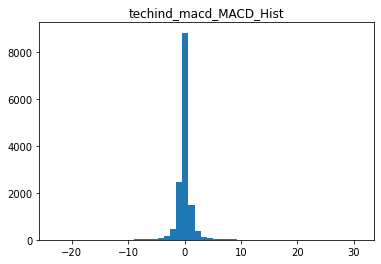

In [6]:
# Pick the column name to check the distribution. 
targcol = "techind_macd_MACD_Hist"
plt.hist(x=df_feature_proc.loc[:, targcol], bins=50) 
plt.title(targcol) 

## Backtesting. 

### Assign the signal. 

In [7]:
# --------------------------------------------------
# Set up the rules or conditions for the signal. 
# --------------------------------------------------

boo_macd_hist_bull = (df_feature_proc["techind_macd_MACD_Hist"] > 0) & (df_feature_proc["techind_macd_MACD_Hist"] <  1)
boo_macd_hist_bear = (df_feature_proc["techind_macd_MACD_Hist"] < 0) & (df_feature_proc["techind_macd_MACD_Hist"] > -1)

boo_macd_line_bull = (df_feature_proc["techind_macd_MACD"] > 0.15) 
boo_macd_sign_bull = (df_feature_proc["techind_macd_MACD_Signal"] > 0.15) 

boo_macd_line_bear = (df_feature_proc["techind_macd_MACD"] < -0.15) 
boo_macd_sign_bear = (df_feature_proc["techind_macd_MACD_Signal"] < -0.15) 

boo_rsi_thres_bull = (df_feature_proc["techind_rsi_t50_RSI"] < 25) 
boo_rsi_thres_bear = (df_feature_proc["techind_rsi_t50_RSI"] > 75) 

boo_pe = (df_feature_proc["vl_pe"] <= 35) & (df_feature_proc["vl_pe"] > 15) 
boo_ps = (df_feature_proc["vl_ps"] <= 50) & (df_feature_proc["vl_ps"] > 25) 

# --------------------------------------------------
# Combine the conditions. 
# --------------------------------------------------

boo_condition_longs = (
	boo_macd_hist_bull \
	& boo_macd_line_bull \
	& boo_macd_sign_bull \
) | ( 
	boo_rsi_thres_bull 
) 

boo_condition_short = (
	boo_macd_hist_bear \
	& boo_macd_line_bear \
	& boo_macd_sign_bear \
) | (
	boo_rsi_thres_bear 
)

# --------------------------------------------------
# Create signal. 
# --------------------------------------------------

# Create the signal for (RuleBased) model. The trade 
# will be executed on the next day at opening price. 
df_feature_proc["signal"] = 0 
df_feature_proc.loc[boo_condition_longs, "signal"] =  1 
df_feature_proc.loc[boo_condition_short, "signal"] = -1 

# Preview. 
df_feature_proc 

,ticker,open,high,low,volume,close,vl_pe,vl_ps,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI,signal
datetime,,,,,,,,,,,,,,,,,
2015-01-05,AMZN,15.35,15.42,15.04,55484000.0,15.11,NaN,NaN,0.0238,-0.1048,-0.1285,15.4163,15.5948,16.0702,43.9526,46.3852,0
2015-01-06,AMZN,15.11,15.15,14.62,70380000.0,14.76,NaN,NaN,-0.0125,-0.1442,-0.1317,15.3543,15.5622,16.0572,40.0520,44.8036,0
2015-01-07,AMZN,14.88,15.06,14.77,52806000.0,14.92,NaN,NaN,-0.0234,-0.1609,-0.1375,15.3130,15.5371,16.0459,42.4891,45.6612,0
2015-01-08,AMZN,15.02,15.16,14.81,61768000.0,15.02,NaN,NaN,-0.0212,-0.1641,-0.1428,15.2854,15.5169,16.0357,44.0495,46.2169,0
2015-01-09,AMZN,15.07,15.14,14.83,51848000.0,14.85,NaN,NaN,-0.0287,-0.1787,-0.1500,15.2436,15.4906,16.0239,41.9750,45.3971,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,JPM,149.69,151.66,148.70,11733300.0,149.70,9.346696,3.547237,0.3921,-0.5297,-0.9218,150.7239,152.8600,151.3728,46.4891,47.2758,0
2022-02-22,JPM,148.18,150.78,147.99,11333500.0,149.43,9.252411,3.511454,0.2715,-0.5825,-0.8540,150.5990,152.7248,151.3533,46.1323,47.1312,0
2022-02-23,JPM,150.66,150.84,145.59,11799000.0,146.30,9.407263,3.570223,-0.0103,-0.8668,-0.8565,150.1881,152.4722,151.3029,42.1247,45.4602,-1


### Check the signal distribution. 

In [8]:
# Check the signal distribution. 
df_feature_proc["signal"].value_counts(normalize=False) 

 0    9031
 1    3615
-1    1754
Name: signal, dtype: int64

### Execute the backtesting. 

In [9]:
"""
Cerebro documentation: 
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/cerebro.py#L747
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/brokers/bbroker.py
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/brokers/ibbroker.py
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/comminfo.py
    — https://github.com/mementum/backtrader/blob/master/backtrader/analyzers/pyfolio.py
"""

# Initiate a "Cerebro" instance and other parameters. 
cerebro = bt.Cerebro()
cash = 100000
comminfo = FixedCommisionScheme()

# Broker setup. 
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

# Add multiple ticker data. 
for ticker in ticker_to_collect:
    df_data = df_feature_proc[df_feature_proc["ticker"] == ticker].sort_values("datetime", axis=0)
    bt_data = SignalData(dataname=df_data)
    cerebro.adddata(bt_data, name=ticker)

# You can add multiple analyser. 
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# You can add multiple strategies. 
logpath = os.path.join(DIR_DATASET, "bt_log.csv")
cerebro.addstrategy(
	RuleBasedStrategy, n_positions=2, min_positions=1, 
	include_short=False, verbose=True, log_file=logpath
)

# Execute the backtesting and get the return value of the strategy. 
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f"Final Portfolio Value: {ending_value:,.2f}")
print(f"Duration: {format_time(duration)}")

Final Portfolio Value: 291,880.94
Duration: 00:00:12


### Visualise the backtesting result. 

In [10]:
# # Unable to run this unless (Matplotlib) is downgraded to (3.2.2). 
# # (BackTrader) has not been updated for a long while. 

# # Plot the results. Disabled because large number of datafeeds all plot separately.
# cerebro.plot() 
# figure = cerebro.plot(style="candlebars")[0][0]
# figure.savefig(f"backtrader.png")

## Porfolio assessment. 

### Get S&P benchmark. 

In [11]:
df_benchmark = web.DataReader("SP500", "fred", "2015", "2023").squeeze()
df_benchmark = df_benchmark.pct_change().tz_localize("UTC")

# Preview. 
df_benchmark

DATE
2015-01-01 00:00:00+00:00         NaN
2015-01-02 00:00:00+00:00         NaN
2015-01-05 00:00:00+00:00   -0.018278
2015-01-06 00:00:00+00:00   -0.008893
2015-01-07 00:00:00+00:00    0.011630
                               ...   
2022-07-18 00:00:00+00:00   -0.008364
2022-07-19 00:00:00+00:00    0.027628
2022-07-20 00:00:00+00:00    0.005896
2022-07-21 00:00:00+00:00    0.009861
2022-07-22 00:00:00+00:00   -0.009332
Name: SP500, Length: 1972, dtype: float64

### Get the transactions. 

In [12]:
# Prepare (pyfolio) inputs. 
pyfolio_analyzer = results[0].analyzers.getbyname("pyfolio")
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items() 

# Get the transaction for longs and short. 
df_transactions = transactions.groupby(level=0)
df_longs = df_transactions.value.apply(lambda x: x.where(x > 0).sum())
df_short = df_transactions.value.apply(lambda x: x.where(x < 0).sum())

### Visualise the result. 

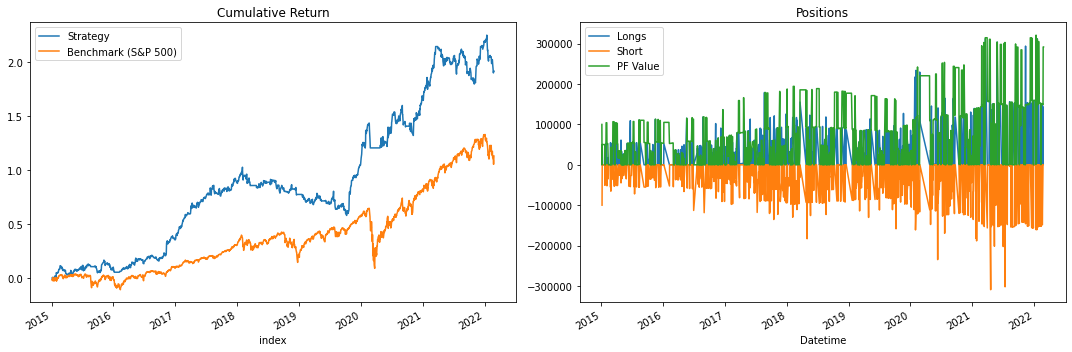

In [13]:
%matplotlib inline 

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# Merge by date index. 
df_compare_benchmark = returns.to_frame("Strategy").join(df_benchmark.to_frame("Benchmark (S&P 500)"))

# Compute the cumulative return. 
df_compare_benchmark.add(1).cumprod().sub(1).plot(ax=axes[0], title="Cumulative Return")

# Plot. 
df_longs.plot(label="Longs", ax=axes[1], title="Positions")
df_short.plot(label="Short", ax=axes[1], title="Positions")
positions.cash.plot(label="PF Value", ax=axes[1])
axes[1].legend()

fig.tight_layout()

/Users/lioneltay/.local/share/virtualenvs/MADS-CAP-gLyVeGLS/lib/python3.8/site-packages/pyfolio/utils.py:316: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  warnings.warn(


Start date,2015-01-05
End date,2022-02-25
Total months,85
,Backtest
Annual return,16.179%
Cumulative returns,191.881%
Annual volatility,13.482%
Sharpe ratio,1.18
Calmar ratio,0.73
Stability,0.91
Max drawdown,-22.092%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.09,2018-02-01,2019-10-09,2019-12-23,493
1,11.06,2021-03-29,2021-11-01,2021-12-08,183
2,10.79,2022-01-14,2022-02-22,NaT,NaN
3,10.72,2020-09-02,2020-11-06,2020-12-17,77
4,9.68,2015-11-06,2016-01-06,2016-05-10,133


Stress Events,mean,min,max
Fall2015,-0.17%,-1.92%,1.06%
New Normal,0.06%,-5.03%,6.75%


Top 10 long positions of all time,max
sid,
LMT,2024416.44%
GS,1431987.74%
AAPL,398983.91%
TSLA,332497.61%
JPM,274134.55%
BA,105021.68%
JNJ,49327.13%
AMZN,42564.63%


Top 10 short positions of all time,max
sid,
LMT,-2925135.41%
AMZN,-2006046.58%
JPM,-1260596.94%
BA,-400030.14%
TSLA,-397995.73%
AAPL,-245578.59%
JNJ,-211891.11%
GS,-1.65%


Top 10 positions of all time,max
sid,
LMT,2925135.41%
AMZN,2006046.58%
GS,1431987.74%
JPM,1260596.94%
BA,400030.14%
AAPL,398983.91%
TSLA,397995.73%
JNJ,211891.11%


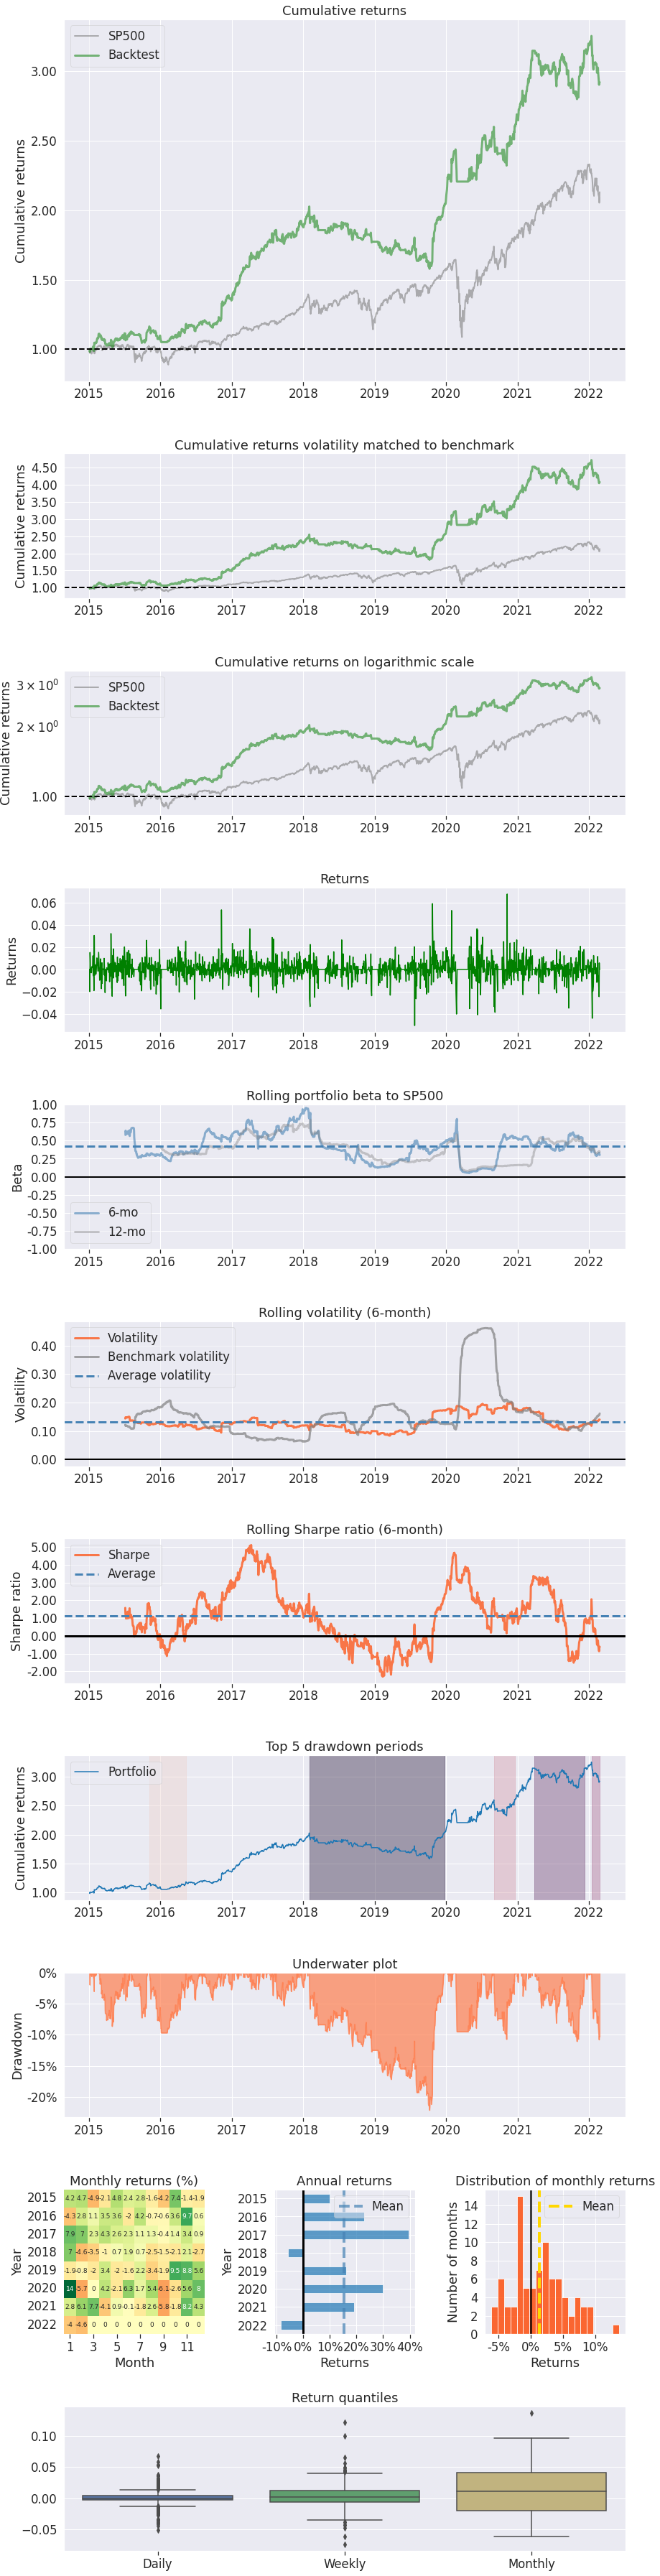

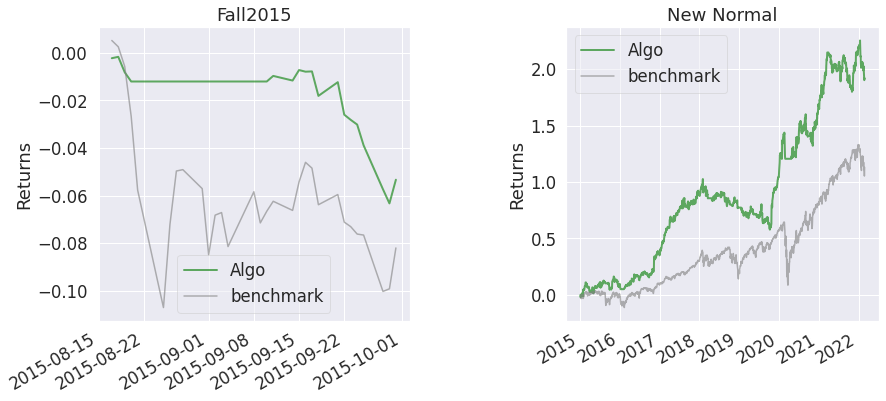

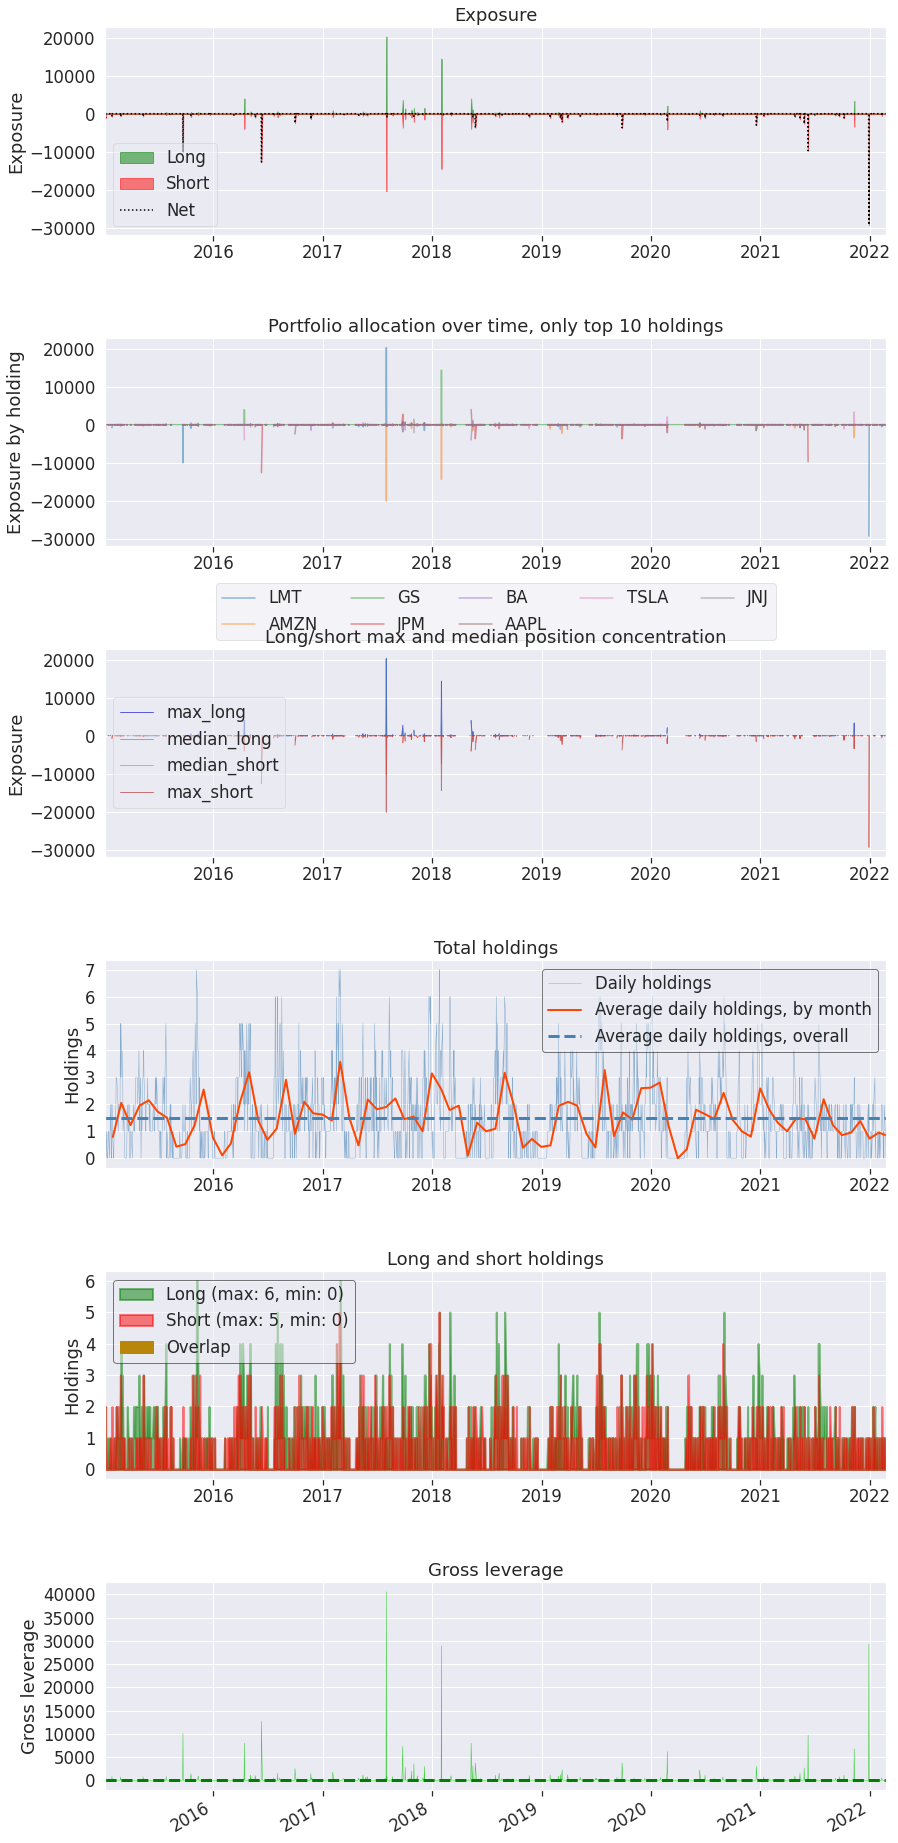

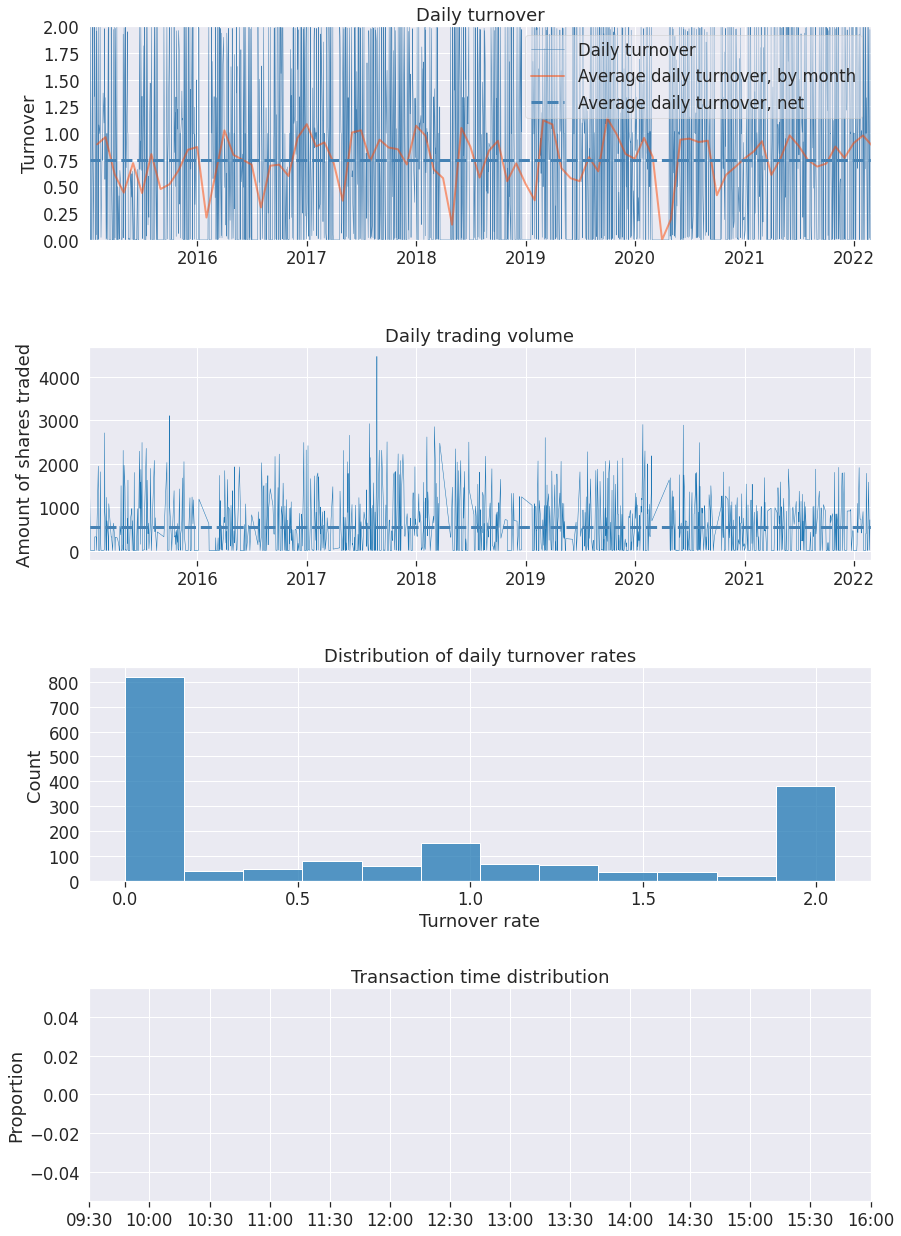

In [14]:
'''
Refer to this get the available functions for plotting: 
— https://mw572.github.io/All%20Weather%20V1/All%20Weather%20V1%20Full%20Analysis.html
— https://www.quantrocket.com/codeload/quant-finance-lectures/quant_finance_lectures/Lecture33-Portfolio-Analysis-with-pyfolio.ipynb.html
'''

%matplotlib inline 

# The datetime index from the benchmark must contain the extact dates. 
idx_benchmark = df_benchmark.index.difference(returns.index) 
idx_benchmark = df_benchmark.index.difference(idx_benchmark) 

pf.create_full_tear_sheet(
	returns,
	transactions=transactions,
	positions=positions,
	benchmark_rets=df_benchmark[idx_benchmark].dropna()
)